In [36]:
import pandas as pd
import numpy as np
import gensim
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from scipy.stats import randint
from time import time
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import concurrent.futures
from datetime import datetime, timezone

In [ ]:
# Read dataset
dataset = pd.read_csv('spam_Emails_data.csv')

# Show first 10 lines
print("Before Data Cleaning")
for i in list(range(10)):
    print(dataset['text'].iloc[i])

# Remove non-unicode chars and other non-words
dataset['text'] = dataset['text'].astype('str').apply(lambda x: x.encode('unicode_escape').decode('utf-8'))
dataset['text'] = dataset['text'].str.replace(r'\\', '', regex=True)
dataset['text'] = dataset['text'].str.replace('escapenumber', '', regex=True)
dataset['text'] = dataset['text'].str.replace(r'\s+', ' ', regex=True)

# Show first 10 lines after cleaning
print("\nAfter Data Cleaning")
for i in list(range(10)):
    print(dataset['text'].iloc[i])

# Show some examples of Spam and Ham
display(dataset.loc[dataset['label'] == 'Spam'].head())
display(dataset.loc[dataset['label'] == 'Ham'].head())

# Change target label to 1 for Spam and 0 for Ham and drop label
dataset['spam'] = np.where(dataset['label'] == 'Spam', 1, 0)
dataset['spam'] = dataset['spam'].astype(int)
dataset = dataset.drop(columns='label')

Before Data Cleaning
viiiiiiagraaaa
only for the ones that want to make her scream .
prodigy scrawny crow define upgrade spongy balboa dither moiseyev schumann variegate ponce bernie cox angeles impassive circulate impend miscellany chalkboard whizzing pend armenian cutlet waring makeshift fletch dispel crest cadet dovetail rapprochement gerry bayreuth selectman wilmington tuttle alchemy itt bullyboy .
caan ' t do . . .

got ice thought look az original message ice operations mailto iceoperations intcx com sent friday october escapenumber escapenumber escapenumber escapenumber pm subject escapelong amended participant agreement dear participant receiving email identified company user administrator legal counsel signatory escapelong participant agreement serves notice intercontinentals intent amend agreement effective december escapenumber escapenumber relevant documentation attached includes contact information questions thank escapelong inc
yo ur wom an ne eds an escapenumber in ch ma

,label,text
0,Spam,viiiiiiagraaaanonly for the ones that want to ...
2,Spam,yo ur wom an ne eds an in ch ma n b e th at ma...
3,Spam,start increasing your odds of success & live s...
5,Spam,img src d http loan co kr img email img gif wi...
12,Spam,luckyday lottery international international p...


,label,text
1,Ham,got ice thought look az original message ice o...
4,Ham,author jra date fri jun new revision websvn ht...
6,Ham,attached is the weekly deal report from 10 / 1...
7,Ham,this is the version that we created earlier th...
8,Ham,pulp writing printing paper welcome to enron's...


Code and concepts adapted from Meduim article "Spam Classification using word2vec embeddings" https://ahujaniharika95.medium.com/spam-classification-using-word2vec-embeddings-70c4ffa56b40

In [ ]:
# Ensure email text is string
dataset['text'] = dataset['text'].astype('str')

# Use simple_preprocess to split string into list of words
dataset['content_list'] = dataset['text'].apply(lambda x: gensim.utils.simple_preprocess(x))

# Show output of preprocessing
dataset.head()

# Count words
dataset['word_len'] = dataset['content_list'].str.len()

# # Limit to 200 words
# dataset['content_list'] = dataset['content_list'].apply(lambda x: x[:200])

# # Reset word count
# dataset['word_len'] = dataset['content_list'].str.len()

print(dataset.describe())

                spam       word_len
count  193852.000000  193852.000000
mean        0.473000     114.199302
std         0.499272      71.004817
min         0.000000       0.000000
25%         0.000000      47.000000
50%         0.000000     107.000000
75%         1.000000     200.000000
max         1.000000     200.000000


In [57]:
# Create train/test split at 80/20
X_train, X_test, y_train, y_test = train_test_split(dataset[['content_list', 'word_len']], dataset['spam'], test_size=0.2)

# Drop the index
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

# Show X_train
print(X_train)

                                             content_list  word_len
0       [pallid, yellow, each, tree, to, fit, your, gh...       119
1       [http, www, marketwatch, com, news, story, asp...        15
2       [transport, agreement, hpl, physical, payback,...       200
3       [re, your, pharmacy, order, cheapest, viagra, ...        58
4       [anatrim, the, up, to, the, moment, and, most,...       200
...                                                   ...       ...
155076  [here, guy, played, football, with, that, you,...       200
155077  [dear, richard, this, week, in, new, releases,...       200
155078  [hoodialifetm, most, effective, weight, loss, ...        99
155079  [awaken, cage, oneill, bumble, increment, bous...        25
155080  [fletch, want, to, re, stress, my, interest, i...        26

[155081 rows x 2 columns]


In [44]:
def document_vector(doc_tokens, model_wv, vocab_words, vector_size):
    # Create a list of the vectors associated with the words in doc_tokens
    valid_word_vectors = [model_wv[token] for token in doc_tokens if token in vocab_words]
    if valid_word_vectors:
        # Average all of the vectors in doc_word to a single vector
        return np.mean(valid_word_vectors, axis=0)
    else:
        # Return a zero vector of the correct dimension if no words are found
        return np.zeros(vector_size)

In [ ]:
def vec_email(X_train, X_test, vector_size, window):
    # Create word2vec model from training data with vector size of 100 with a context window of +-5 words by default
    w2v_model = gensim.models.Word2Vec(X_train, vector_size=vector_size, window=window, min_count=1)

    # Get vocabulary from model
    words = set(w2v_model.wv.index_to_key)
    # Get vector size
    vector_size = w2v_model.wv.vector_size

    # For Train and Test, get average of all matching words in each email as an n dimension vector
    X_train_vect = np.array([document_vector(email_words, w2v_model.wv, words, vector_size)
                            for email_words in X_train])
    
    # For Test, capture the start and end time to calculate time needed for inference 
    vec_start_time = int(time() * 1000)
    X_test_vect = np.array([document_vector(email_words, w2v_model.wv, words, vector_size)
                        for email_words in X_test])
    vec_end_time = int(time() * 1000)
    vec_run_time = vec_end_time - vec_start_time

    return X_train_vect, X_test_vect, vec_run_time

In [ ]:
# Return a string of the current UTC time, down to the second
def print_now():
    current_utc_time = datetime.now(timezone.utc)
    formatted_time = current_utc_time.strftime("%Y-%m-%d %H:%M:%S")
    return(formatted_time)

The function below is a wrapper for vectorizing the emails and then builfing a Random Forest model for inference

In [ ]:
def do_rf_reg(X_train, y_train, X_test, y_test, window_size, vector_size):
        print(f"{print_now()} Start vector_size={vector_size} window_size={window_size}")
        # Get the average vector for email
        X_train_vect, X_test_vect, vec_run_time = vec_email(X_test=X_test['content_list'], X_train=X_train['content_list'], window=window_size, vector_size=vector_size)

        # Reshape the word count for stacking with the vector, make 1-D array
        X_train_word_len = X_train['word_len'].to_numpy().reshape(-1, 1)
        X_test_word_len = X_test['word_len'].to_numpy().reshape(-1, 1)

        # Stack vector array with word cound
        X_train_vect = np.hstack((X_train_vect, X_train_word_len))
        X_test_vect = np.hstack((X_test_vect,X_test_word_len))

        # Build and fit random forest model
        model = RandomForestClassifier(random_state=12)
        model.fit(X_train_vect, y_train)

        # Get inference prediction time
        inf_start_time = int(time() * 1000)
        y_pred = model.predict(X_test_vect)
        inf_end_time = int(time() * 1000)
        inf_run_time = inf_end_time - inf_start_time

        # For this function, only keep F1
        f1 = f1_score(y_test, y_pred)
        print(f"{print_now()} End vector_size={vector_size} window_size={window_size} vector_run_time={vec_run_time} inf_run_time={inf_run_time} f1={f1:.4f}")
        return vector_size, window_size, vec_run_time, inf_run_time, f1, y_pred

Vectorizing the email can be time consuming.  Since we want to search over a number of variables, leverage multi-threading to speed up the process.  We are searching for the optimial vector and window size.

In [ ]:
# Search list for vector size
vector_size_list = [10, 20, 50, 100, 200, 500]

# Search list for window size, this is how many words before and after that are considered when creating vector
window_size_list = [3, 5, 7, 10, 20, 50, 100]

vec_list = []
win_list = []

# Number of CPU cores to use
max_workers = 6

# Default window size
window_size = 5

# Create list of vector size parameters for testing
for vector_size in vector_size_list:
    vec_list.append([X_train, y_train, X_test, y_test, window_size, vector_size])

# Default vector size
vector_size = 100

# Create list of window size parameters for testing
for window_size in window_size_list:
    win_list.append([X_train, y_train, X_test, y_test, window_size, vector_size])

futures = []

# Best practice to ensure forking
if __name__ == '__main__':
    # We will be searching over vector and window size
    for mt_list in [vec_list, win_list]:
        # Run concurrently to save time and leverage multiple CPUs
        with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
            # Create queue to be ran and submit
            for mt in mt_list:
                # The '*' expands the list of parameters
                future = executor.submit(do_rf_reg, *mt)
                # Append to list
                futures.append(future)

        # Results list
        results = []
        # Once thread completes, gather results or note error
        for future in concurrent.futures.as_completed(futures):
            try:
                result = future.result()
                results.append(result)
                print(f"Result received: {result}")
            except Exception as e:
                print(f"A task generated an exception: {e}")

2025-06-15 18:21:22 Start vector_size=10 window_size=5
2025-06-15 18:21:22 Start vector_size=20 window_size=5
2025-06-15 18:21:22 Start vector_size=50 window_size=5
2025-06-15 18:21:22 Start vector_size=100 window_size=5
2025-06-15 18:21:22 Start vector_size=200 window_size=52025-06-15 18:21:22 Start vector_size=500 window_size=5

2025-06-15 18:42:20 End vector_size=10 window_size=5 vector_run_time=176940 inf_run_time=329 f1=0.9696
2025-06-15 18:42:48 End vector_size=20 window_size=5 vector_run_time=175297 inf_run_time=350 f1=0.9721
2025-06-15 18:43:46 End vector_size=50 window_size=5 vector_run_time=172876 inf_run_time=387 f1=0.9740
2025-06-15 18:44:44 End vector_size=100 window_size=5 vector_run_time=165133 inf_run_time=419 f1=0.9737
2025-06-15 18:45:53 End vector_size=200 window_size=5 vector_run_time=143922 inf_run_time=473 f1=0.9743
2025-06-15 18:48:22 End vector_size=500 window_size=5 vector_run_time=106421 inf_run_time=680 f1=0.9738
Result received: (100, 5, 165133, 419, 0.97366

Let's manually run a test with lower vector and window size to test the change in execution time.  window_size of 50 and vector_size of 100 looks to be optimal so we will run that last to get the production model.

In [64]:
# Example run with sub-optimal values
window_size = 3
vector_size = 10
vector_size, window_size, vec_run_time, inf_run_time, f1, y_pred = do_rf_reg(X_train, y_train, X_test, y_test, window_size, vector_size)

# Production run with optimal parameters identified above
window_size = 50
vector_size = 100
vector_size, window_size, vec_run_time, inf_run_time, f1, y_pred = do_rf_reg(X_train, y_train, X_test, y_test, window_size, vector_size)

2025-06-16 09:53:19 Start vector_size=10 window_size=3
2025-06-16 09:54:42 End vector_size=10 window_size=3 vector_run_time=3499 inf_run_time=322 f1=0.9627
2025-06-16 09:54:42 Start vector_size=100 window_size=50
2025-06-16 09:58:44 End vector_size=100 window_size=50 vector_run_time=3793 inf_run_time=425 f1=0.9731


In [ ]:
# Calculate accuracy, precision, recall, and F1
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred)

# Output scores
print(f"Accuracy: {accuracy:.4f} Precision: {precision:.4f}  Recall: {recall:.4f} F1: {f1:.4f}")
print(classification_report(y_test, y_pred, digits=4),"\n")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9750 Precision: 0.9737  Recall: 0.9731 F1: 0.9734
              precision    recall  f1-score   support

           0     0.9762    0.9767    0.9765     20578
           1     0.9737    0.9731    0.9734     18193

    accuracy                         0.9750     38771
   macro avg     0.9750    0.9749    0.9749     38771
weighted avg     0.9750    0.9750    0.9750     38771
 

[[20099   479]
 [  489 17704]]


We will create a results dataframe with True Positive, True Negative, False Positive, and False Negative.

In [ ]:
# Start with X_test
df_results = X_test.copy()

# Add predictions and ground truth
df_results['y_pred'] = y_pred
df_results['y_test'] = y_test

# Add label for TP, TN, FN, and FP
df_results['class'] = np.where((df_results['y_test'] == 1) & (df_results['y_pred'] == 1), 'TP', '')
df_results['class'] = np.where((df_results['y_test'] == 0) & (df_results['y_pred'] == 0), 'TN', df_results['class'])
df_results['class'] = np.where((df_results['y_test'] == 1) & (df_results['y_pred'] == 0), 'FN', df_results['class'])
df_results['class'] = np.where((df_results['y_test'] == 0) & (df_results['y_pred']) == 1, 'FP', df_results['class'])

print(df_results.describe())


           word_len        y_pred       y_test
count  38771.000000  38771.000000  7783.000000
mean     113.962446      0.468985     0.471798
std       70.755421      0.499044     0.499236
min        0.000000      0.000000     0.000000
25%       48.000000      0.000000     0.000000
50%      106.000000      0.000000     0.000000
75%      200.000000      1.000000     1.000000
max      200.000000      1.000000     1.000000


In [ ]:
# Get averages for each
df_len = df_results.groupby(df_results['class']).mean()
print(df_len)

# Look at a few examples of false negative
df_fn = df_results.loc[df_results['class'] == 'FN']
print(df_fn['content_list'].head())

# Look at a few examples of false positive
df_fp = df_results.loc[df_results['class'] == 'FP']
print(df_fp['content_list'].head())

         word_len    y_pred  y_test
class                              
       113.886279  0.470698     NaN
FN     119.382143  0.000000     1.0
FP     109.156499  1.000000     0.0
TN     120.159479  0.000000     0.0
TP     106.370327  1.000000     1.0
2      [original, message, martinsen, aaron, sent, tu...
46     [at, pm, larry, wall, wrote, nope, hash, is, m...
70     [hi, all, for, years, ve, had, frotz, installe...
74     [when, monday, november, am, pm, gmt, central,...
105    [original, message, from, nicoll, kenny, sent,...
Name: content_list, dtype: object
8     [in, attention, of, pr, department, ni, intere...
25    [xf, xf, xe, xe, xecxe, xe, xe, xe, xf, xf, xf...
30    [top, morning, http, alanschornfd, net, escape...
53    [leisure, direct, inc, ldti, ob, rating, under...
80    [good, morning, offer, latest, oem, packages, ...
Name: content_list, dtype: object


C:\Users\mikes\AppData\Local\Temp\ipykernel_33028\1316344670.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_len = df_results.groupby(df_results['class']).mean()


Let's create word cloud for the four classifications above to see if there is anything we can learn from the common words used, specifically in FP and FN.  Gemini 2.5 Flash used for some of the WordCloud code.

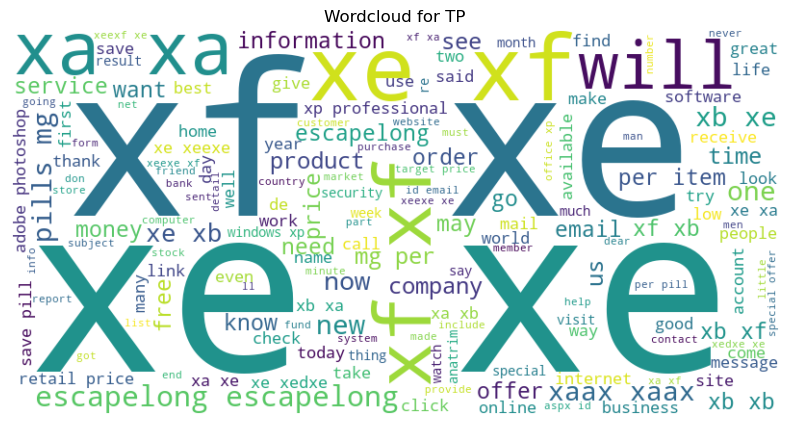

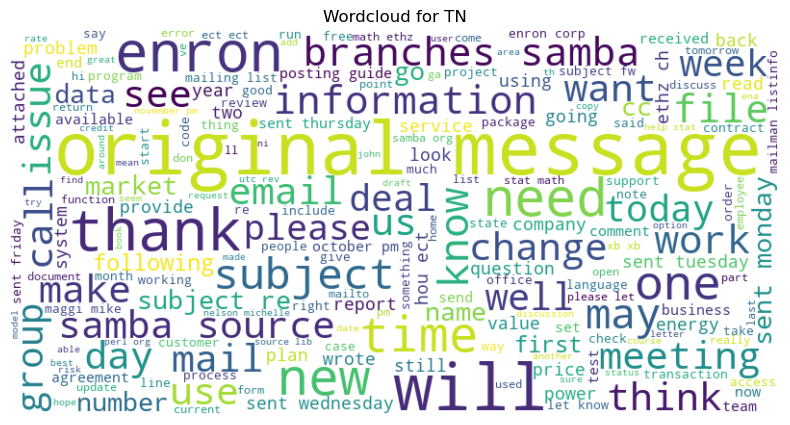

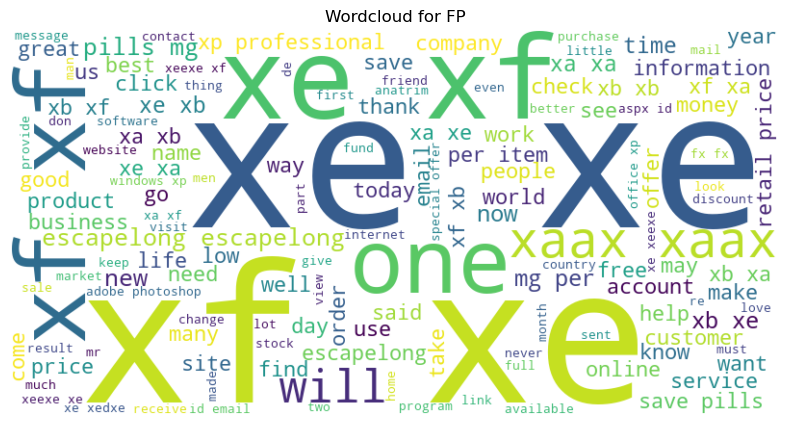

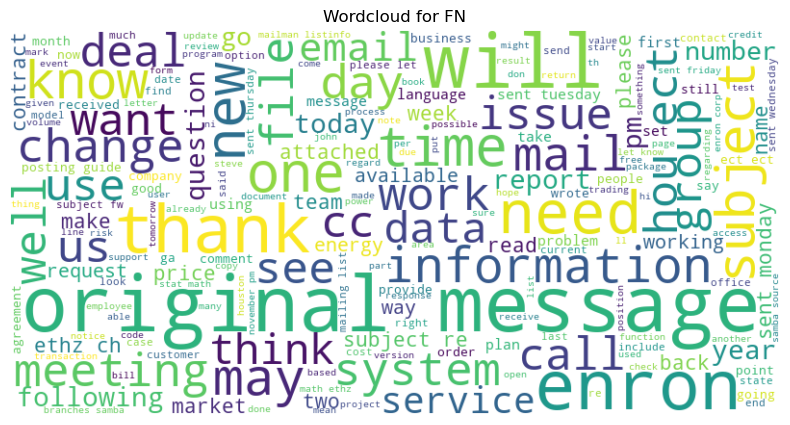

In [ ]:
# Loop for each type.
for conf_label in ['TP', 'TN', 'FP', 'FN']:
    # Get dataframe with only the correct labels
    df_wordcloud = df_results.loc[df_results['class'] == conf_label]
    all_words = []
    # Iterate and get words in a single list
    for index, row in df_wordcloud.iterrows():
        all_words.extend(row['content_list'])

    # Convert list of words into single long string
    text_for_wordcloud = " ".join(all_words)

    # Create wordcloud from string
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        min_font_size=10
    ).generate(text_for_wordcloud)

    # Parameters from Gemini
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off') # Hide the axes
    plt.title(f"Wordcloud for {conf_label}")
    plt.show()
